In [1]:
import torch
import torch.nn as nn
from torch.optim import Adam
import numpy as np
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics import accuracy_score

from tqdm.notebook import tqdm
import random
import glob
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os

Run once to clean the naming withing the test folder

In [2]:
#for filename in glob.glob('test/*'):
#    os.rename(filename, filename.split('_')[0]+'.jpg')   

In [3]:
# Image transformations
image_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
    ])

# transforms.ToTensor() also changes the images
# from (H x W x C) to (C x H x W) in the range [0.0, 1.0]

test_transforms = transforms.Compose([transforms.ToTensor(),])

In [4]:
dataset = datasets.ImageFolder(root="train", transform=image_transforms)
test_dataset = datasets.ImageFolder(root="test", transform=test_transforms)

Train/Validation Split

In [5]:
batch_size = 8
validation_split = .2

dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

Define AlexNet Architecture

In [6]:
NUM_CLASSES = 29

In [7]:
def Convolution_Layer(n_input_channels, n_output_channels, conv_kernel_size = 3,
                   conv_stride = 1, conv_padding = 1):
    layers = nn.Sequential(
        nn.Conv2d(n_input_channels,
                  n_output_channels,
                  kernel_size = conv_kernel_size,
                  stride = conv_stride,
                  padding = 1),
        nn.BatchNorm2d(n_output_channels),
        nn.ReLU(inplace=True),
    )
    return layers

In [8]:
class AlexNet(nn.Module):
    def __init__(self):
        super(AlexNet, self).__init__()
        
        self.conv_steps = nn.Sequential(
            Convolution_Layer(3, 96, conv_kernel_size = 11, conv_stride = 4, conv_padding = 2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Convolution_Layer(96, 256, conv_kernel_size = 5, conv_padding = 2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            Convolution_Layer(256, 384),
            Convolution_Layer(384, 384),
            Convolution_Layer(384, 256),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        
        self.avg_pool = nn.AdaptiveAvgPool2d((6, 6))
        
        self.dense_steps = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4608),
            nn.ReLU(inplace=True),
            nn.Linear(4608, 4608),
            nn.ReLU(inplace=True),
            nn.Linear(4608, NUM_CLASSES),
        )
    
    def forward(self, x):
        x = self.conv_steps(x)
        x = self.avg_pool(x)
        x = torch.flatten(x, 1)
        x = self.dense_steps(x)
        return x

In [9]:
skip_train = False

model = AlexNet()

model_filename = 'model/model_alexnet_asl.pt'

if (model_filename in glob.glob('model/*')):
    model = torch.load(model_filename)
    skip_train = True

# Move to gpu
model = model.to('cuda')

# Distribute across 2 gpus
model = nn.DataParallel(model)

criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.00001)

In [10]:
if (not skip_train):

    n_epochs = 10
    
    for epoch in tqdm(range(n_epochs)):
        running_loss = 0.0
        for i, (data, targets) in tqdm(enumerate(train_loader), f'Traning: Epoch {epoch + 1}'):
            data = data/256.0
            out = model(data)
            targets = targets.to('cuda')
            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            if i % 64 == 63:
                print(f'Epoch: {epoch + 1} || Step {i + 1} >> Loss: {round(running_loss / 64, 3)}')
                running_loss = 0.0

  0%|          | 0/10 [00:00<?, ?it/s]

Traning: Epoch 1: 0it [00:00, ?it/s]

Epoch: 1 || Step 64 >> Loss: 3.51
Epoch: 1 || Step 128 >> Loss: 3.585
Epoch: 1 || Step 192 >> Loss: 3.421
Epoch: 1 || Step 256 >> Loss: 3.316
Epoch: 1 || Step 320 >> Loss: 3.211
Epoch: 1 || Step 384 >> Loss: 3.316
Epoch: 1 || Step 448 >> Loss: 3.29
Epoch: 1 || Step 512 >> Loss: 3.261
Epoch: 1 || Step 576 >> Loss: 3.195
Epoch: 1 || Step 640 >> Loss: 3.114
Epoch: 1 || Step 704 >> Loss: 3.076
Epoch: 1 || Step 768 >> Loss: 3.105
Epoch: 1 || Step 832 >> Loss: 3.121
Epoch: 1 || Step 896 >> Loss: 3.074
Epoch: 1 || Step 960 >> Loss: 3.039
Epoch: 1 || Step 1024 >> Loss: 2.913
Epoch: 1 || Step 1088 >> Loss: 2.889
Epoch: 1 || Step 1152 >> Loss: 2.801
Epoch: 1 || Step 1216 >> Loss: 2.707
Epoch: 1 || Step 1280 >> Loss: 2.701
Epoch: 1 || Step 1344 >> Loss: 2.602
Epoch: 1 || Step 1408 >> Loss: 2.626
Epoch: 1 || Step 1472 >> Loss: 2.492
Epoch: 1 || Step 1536 >> Loss: 2.564
Epoch: 1 || Step 1600 >> Loss: 2.425
Epoch: 1 || Step 1664 >> Loss: 2.454
Epoch: 1 || Step 1728 >> Loss: 2.445
Epoch: 1 || Step 17

Traning: Epoch 2: 0it [00:00, ?it/s]

Epoch: 2 || Step 64 >> Loss: 1.127
Epoch: 2 || Step 128 >> Loss: 1.055
Epoch: 2 || Step 192 >> Loss: 0.917
Epoch: 2 || Step 256 >> Loss: 1.017
Epoch: 2 || Step 320 >> Loss: 0.971
Epoch: 2 || Step 384 >> Loss: 0.919
Epoch: 2 || Step 448 >> Loss: 1.092
Epoch: 2 || Step 512 >> Loss: 0.941
Epoch: 2 || Step 576 >> Loss: 1.003
Epoch: 2 || Step 640 >> Loss: 1.049
Epoch: 2 || Step 704 >> Loss: 0.942
Epoch: 2 || Step 768 >> Loss: 0.88
Epoch: 2 || Step 832 >> Loss: 0.979
Epoch: 2 || Step 896 >> Loss: 0.955
Epoch: 2 || Step 960 >> Loss: 0.945
Epoch: 2 || Step 1024 >> Loss: 1.08
Epoch: 2 || Step 1088 >> Loss: 1.056
Epoch: 2 || Step 1152 >> Loss: 0.992
Epoch: 2 || Step 1216 >> Loss: 0.905
Epoch: 2 || Step 1280 >> Loss: 1.005
Epoch: 2 || Step 1344 >> Loss: 1.026
Epoch: 2 || Step 1408 >> Loss: 0.915
Epoch: 2 || Step 1472 >> Loss: 1.059
Epoch: 2 || Step 1536 >> Loss: 0.938
Epoch: 2 || Step 1600 >> Loss: 0.997
Epoch: 2 || Step 1664 >> Loss: 1.009
Epoch: 2 || Step 1728 >> Loss: 1.025
Epoch: 2 || Step 17

Traning: Epoch 3: 0it [00:00, ?it/s]

Epoch: 3 || Step 64 >> Loss: 0.694
Epoch: 3 || Step 128 >> Loss: 0.502
Epoch: 3 || Step 192 >> Loss: 0.633
Epoch: 3 || Step 256 >> Loss: 0.546
Epoch: 3 || Step 320 >> Loss: 0.617
Epoch: 3 || Step 384 >> Loss: 0.643
Epoch: 3 || Step 448 >> Loss: 0.663
Epoch: 3 || Step 512 >> Loss: 0.57
Epoch: 3 || Step 576 >> Loss: 0.57
Epoch: 3 || Step 640 >> Loss: 0.797
Epoch: 3 || Step 704 >> Loss: 0.667
Epoch: 3 || Step 768 >> Loss: 0.608
Epoch: 3 || Step 832 >> Loss: 0.648
Epoch: 3 || Step 896 >> Loss: 0.631
Epoch: 3 || Step 960 >> Loss: 0.629
Epoch: 3 || Step 1024 >> Loss: 0.623
Epoch: 3 || Step 1088 >> Loss: 0.517
Epoch: 3 || Step 1152 >> Loss: 0.543
Epoch: 3 || Step 1216 >> Loss: 0.671
Epoch: 3 || Step 1280 >> Loss: 0.65
Epoch: 3 || Step 1344 >> Loss: 0.736
Epoch: 3 || Step 1408 >> Loss: 0.571
Epoch: 3 || Step 1472 >> Loss: 0.556
Epoch: 3 || Step 1536 >> Loss: 0.592
Epoch: 3 || Step 1600 >> Loss: 0.664
Epoch: 3 || Step 1664 >> Loss: 0.578
Epoch: 3 || Step 1728 >> Loss: 0.639
Epoch: 3 || Step 179

Traning: Epoch 4: 0it [00:00, ?it/s]

Epoch: 4 || Step 64 >> Loss: 0.461
Epoch: 4 || Step 128 >> Loss: 0.448
Epoch: 4 || Step 192 >> Loss: 0.415
Epoch: 4 || Step 256 >> Loss: 0.389
Epoch: 4 || Step 320 >> Loss: 0.464
Epoch: 4 || Step 384 >> Loss: 0.34
Epoch: 4 || Step 448 >> Loss: 0.419
Epoch: 4 || Step 512 >> Loss: 0.406
Epoch: 4 || Step 576 >> Loss: 0.373
Epoch: 4 || Step 640 >> Loss: 0.37
Epoch: 4 || Step 704 >> Loss: 0.421
Epoch: 4 || Step 768 >> Loss: 0.456
Epoch: 4 || Step 832 >> Loss: 0.366
Epoch: 4 || Step 896 >> Loss: 0.458
Epoch: 4 || Step 960 >> Loss: 0.49
Epoch: 4 || Step 1024 >> Loss: 0.4
Epoch: 4 || Step 1088 >> Loss: 0.394
Epoch: 4 || Step 1152 >> Loss: 0.381
Epoch: 4 || Step 1216 >> Loss: 0.523
Epoch: 4 || Step 1280 >> Loss: 0.342
Epoch: 4 || Step 1344 >> Loss: 0.381
Epoch: 4 || Step 1408 >> Loss: 0.419
Epoch: 4 || Step 1472 >> Loss: 0.354
Epoch: 4 || Step 1536 >> Loss: 0.405
Epoch: 4 || Step 1600 >> Loss: 0.405
Epoch: 4 || Step 1664 >> Loss: 0.464
Epoch: 4 || Step 1728 >> Loss: 0.418
Epoch: 4 || Step 1792 

Traning: Epoch 5: 0it [00:00, ?it/s]

Epoch: 5 || Step 64 >> Loss: 0.347
Epoch: 5 || Step 128 >> Loss: 0.293
Epoch: 5 || Step 192 >> Loss: 0.281
Epoch: 5 || Step 256 >> Loss: 0.336
Epoch: 5 || Step 320 >> Loss: 0.299
Epoch: 5 || Step 384 >> Loss: 0.336
Epoch: 5 || Step 448 >> Loss: 0.356
Epoch: 5 || Step 512 >> Loss: 0.348
Epoch: 5 || Step 576 >> Loss: 0.335
Epoch: 5 || Step 640 >> Loss: 0.332
Epoch: 5 || Step 704 >> Loss: 0.271
Epoch: 5 || Step 768 >> Loss: 0.361
Epoch: 5 || Step 832 >> Loss: 0.228
Epoch: 5 || Step 896 >> Loss: 0.34
Epoch: 5 || Step 960 >> Loss: 0.325
Epoch: 5 || Step 1024 >> Loss: 0.265
Epoch: 5 || Step 1088 >> Loss: 0.338
Epoch: 5 || Step 1152 >> Loss: 0.385
Epoch: 5 || Step 1216 >> Loss: 0.322
Epoch: 5 || Step 1280 >> Loss: 0.338
Epoch: 5 || Step 1344 >> Loss: 0.332
Epoch: 5 || Step 1408 >> Loss: 0.309
Epoch: 5 || Step 1472 >> Loss: 0.265
Epoch: 5 || Step 1536 >> Loss: 0.243
Epoch: 5 || Step 1600 >> Loss: 0.363
Epoch: 5 || Step 1664 >> Loss: 0.213
Epoch: 5 || Step 1728 >> Loss: 0.318
Epoch: 5 || Step 1

Traning: Epoch 6: 0it [00:00, ?it/s]

Epoch: 6 || Step 64 >> Loss: 0.268
Epoch: 6 || Step 128 >> Loss: 0.268
Epoch: 6 || Step 192 >> Loss: 0.297
Epoch: 6 || Step 256 >> Loss: 0.292
Epoch: 6 || Step 320 >> Loss: 0.291
Epoch: 6 || Step 384 >> Loss: 0.308
Epoch: 6 || Step 448 >> Loss: 0.27
Epoch: 6 || Step 512 >> Loss: 0.27
Epoch: 6 || Step 576 >> Loss: 0.303
Epoch: 6 || Step 640 >> Loss: 0.29
Epoch: 6 || Step 704 >> Loss: 0.277
Epoch: 6 || Step 768 >> Loss: 0.27
Epoch: 6 || Step 832 >> Loss: 0.354
Epoch: 6 || Step 896 >> Loss: 0.255
Epoch: 6 || Step 960 >> Loss: 0.28
Epoch: 6 || Step 1024 >> Loss: 0.23
Epoch: 6 || Step 1088 >> Loss: 0.282
Epoch: 6 || Step 1152 >> Loss: 0.274
Epoch: 6 || Step 1216 >> Loss: 0.362
Epoch: 6 || Step 1280 >> Loss: 0.319
Epoch: 6 || Step 1344 >> Loss: 0.272
Epoch: 6 || Step 1408 >> Loss: 0.27
Epoch: 6 || Step 1472 >> Loss: 0.272
Epoch: 6 || Step 1536 >> Loss: 0.215
Epoch: 6 || Step 1600 >> Loss: 0.351
Epoch: 6 || Step 1664 >> Loss: 0.236
Epoch: 6 || Step 1728 >> Loss: 0.24
Epoch: 6 || Step 1792 >> 

Traning: Epoch 7: 0it [00:00, ?it/s]

Epoch: 7 || Step 64 >> Loss: 0.184
Epoch: 7 || Step 128 >> Loss: 0.278
Epoch: 7 || Step 192 >> Loss: 0.206
Epoch: 7 || Step 256 >> Loss: 0.211
Epoch: 7 || Step 320 >> Loss: 0.228
Epoch: 7 || Step 384 >> Loss: 0.264
Epoch: 7 || Step 448 >> Loss: 0.224
Epoch: 7 || Step 512 >> Loss: 0.279
Epoch: 7 || Step 576 >> Loss: 0.285
Epoch: 7 || Step 640 >> Loss: 0.311
Epoch: 7 || Step 704 >> Loss: 0.238
Epoch: 7 || Step 768 >> Loss: 0.204
Epoch: 7 || Step 832 >> Loss: 0.248
Epoch: 7 || Step 896 >> Loss: 0.24
Epoch: 7 || Step 960 >> Loss: 0.321
Epoch: 7 || Step 1024 >> Loss: 0.267
Epoch: 7 || Step 1088 >> Loss: 0.244
Epoch: 7 || Step 1152 >> Loss: 0.247
Epoch: 7 || Step 1216 >> Loss: 0.246
Epoch: 7 || Step 1280 >> Loss: 0.25
Epoch: 7 || Step 1344 >> Loss: 0.231
Epoch: 7 || Step 1408 >> Loss: 0.177
Epoch: 7 || Step 1472 >> Loss: 0.212
Epoch: 7 || Step 1536 >> Loss: 0.275
Epoch: 7 || Step 1600 >> Loss: 0.243
Epoch: 7 || Step 1664 >> Loss: 0.187
Epoch: 7 || Step 1728 >> Loss: 0.214
Epoch: 7 || Step 17

Traning: Epoch 8: 0it [00:00, ?it/s]

Epoch: 8 || Step 64 >> Loss: 0.207
Epoch: 8 || Step 128 >> Loss: 0.393
Epoch: 8 || Step 192 >> Loss: 0.31
Epoch: 8 || Step 256 >> Loss: 0.258
Epoch: 8 || Step 320 >> Loss: 0.144
Epoch: 8 || Step 384 >> Loss: 0.21
Epoch: 8 || Step 448 >> Loss: 0.242
Epoch: 8 || Step 512 >> Loss: 0.244
Epoch: 8 || Step 576 >> Loss: 0.262
Epoch: 8 || Step 640 >> Loss: 0.249
Epoch: 8 || Step 704 >> Loss: 0.264
Epoch: 8 || Step 768 >> Loss: 0.158
Epoch: 8 || Step 832 >> Loss: 0.165
Epoch: 8 || Step 896 >> Loss: 0.282
Epoch: 8 || Step 960 >> Loss: 0.249
Epoch: 8 || Step 1024 >> Loss: 0.224
Epoch: 8 || Step 1088 >> Loss: 0.308
Epoch: 8 || Step 1152 >> Loss: 0.238
Epoch: 8 || Step 1216 >> Loss: 0.209
Epoch: 8 || Step 1280 >> Loss: 0.202
Epoch: 8 || Step 1344 >> Loss: 0.234
Epoch: 8 || Step 1408 >> Loss: 0.357
Epoch: 8 || Step 1472 >> Loss: 0.236
Epoch: 8 || Step 1536 >> Loss: 0.273
Epoch: 8 || Step 1600 >> Loss: 0.27
Epoch: 8 || Step 1664 >> Loss: 0.213
Epoch: 8 || Step 1728 >> Loss: 0.233
Epoch: 8 || Step 179

Traning: Epoch 9: 0it [00:00, ?it/s]

Epoch: 9 || Step 64 >> Loss: 0.319
Epoch: 9 || Step 128 >> Loss: 0.317
Epoch: 9 || Step 192 >> Loss: 0.174
Epoch: 9 || Step 256 >> Loss: 0.188
Epoch: 9 || Step 320 >> Loss: 0.187
Epoch: 9 || Step 384 >> Loss: 0.173
Epoch: 9 || Step 448 >> Loss: 0.21
Epoch: 9 || Step 512 >> Loss: 0.237
Epoch: 9 || Step 576 >> Loss: 0.167
Epoch: 9 || Step 640 >> Loss: 0.199
Epoch: 9 || Step 704 >> Loss: 0.231
Epoch: 9 || Step 768 >> Loss: 0.174
Epoch: 9 || Step 832 >> Loss: 0.168
Epoch: 9 || Step 896 >> Loss: 0.181
Epoch: 9 || Step 960 >> Loss: 0.236
Epoch: 9 || Step 1024 >> Loss: 0.165
Epoch: 9 || Step 1088 >> Loss: 0.194
Epoch: 9 || Step 1152 >> Loss: 0.199
Epoch: 9 || Step 1216 >> Loss: 0.176
Epoch: 9 || Step 1280 >> Loss: 0.197
Epoch: 9 || Step 1344 >> Loss: 0.212
Epoch: 9 || Step 1408 >> Loss: 0.175
Epoch: 9 || Step 1472 >> Loss: 0.198
Epoch: 9 || Step 1536 >> Loss: 0.226
Epoch: 9 || Step 1600 >> Loss: 0.229
Epoch: 9 || Step 1664 >> Loss: 0.207
Epoch: 9 || Step 1728 >> Loss: 0.184
Epoch: 9 || Step 1

Traning: Epoch 10: 0it [00:00, ?it/s]

Epoch: 10 || Step 64 >> Loss: 0.177
Epoch: 10 || Step 128 >> Loss: 0.147
Epoch: 10 || Step 192 >> Loss: 0.208
Epoch: 10 || Step 256 >> Loss: 0.117
Epoch: 10 || Step 320 >> Loss: 0.2
Epoch: 10 || Step 384 >> Loss: 0.165
Epoch: 10 || Step 448 >> Loss: 0.135
Epoch: 10 || Step 512 >> Loss: 0.17
Epoch: 10 || Step 576 >> Loss: 0.121
Epoch: 10 || Step 640 >> Loss: 0.16
Epoch: 10 || Step 704 >> Loss: 0.222
Epoch: 10 || Step 768 >> Loss: 0.163
Epoch: 10 || Step 832 >> Loss: 0.176
Epoch: 10 || Step 896 >> Loss: 0.186
Epoch: 10 || Step 960 >> Loss: 0.182
Epoch: 10 || Step 1024 >> Loss: 0.239
Epoch: 10 || Step 1088 >> Loss: 0.182
Epoch: 10 || Step 1152 >> Loss: 0.215
Epoch: 10 || Step 1216 >> Loss: 0.145
Epoch: 10 || Step 1280 >> Loss: 0.156
Epoch: 10 || Step 1344 >> Loss: 0.129
Epoch: 10 || Step 1408 >> Loss: 0.18
Epoch: 10 || Step 1472 >> Loss: 0.131
Epoch: 10 || Step 1536 >> Loss: 0.192
Epoch: 10 || Step 1600 >> Loss: 0.206
Epoch: 10 || Step 1664 >> Loss: 0.173
Epoch: 10 || Step 1728 >> Loss: 0

In [11]:
accuracies = []
val_loss = 0

for data, targets in tqdm(validation_loader):
    inpt = data/256.0
    out = model(inpt)
    # Convert to probabilities
    ps = torch.exp(out)
    pred = torch.max(ps, dim=1)[1].cpu().numpy()
    accuracies.append(accuracy_score(pred, targets))

print(np.mean(accuracies))

  0%|          | 0/2175 [00:00<?, ?it/s]

0.9388505747126437


In [12]:
Idx_to_letter_dict = {v: k for k, v in dataset.class_to_idx.items()}

In [13]:
if (not skip_train):
    torch.save(model, model_filename)

C:\Users\alcob\anaconda3\envs\deeplearning\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type AlexNet. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


In [14]:
test_imgs = []
test_labels = []

for img, _ in test_dataset:
    test_imgs.append(img)
    
for file in glob.glob('test/*.*'):
    test_labels.append(file.split('\\')[1].split('.')[0])

In [15]:
predictions = []
for img in test_imgs:
    out = model(img.reshape(1, 3, 200, 200))
    ps = torch.exp(out)
    pred = torch.max(ps, dim=1)[1].cpu().numpy()
    predictions.append(Idx_to_letter_dict[pred.item()])

<Figure size 432x288 with 0 Axes>

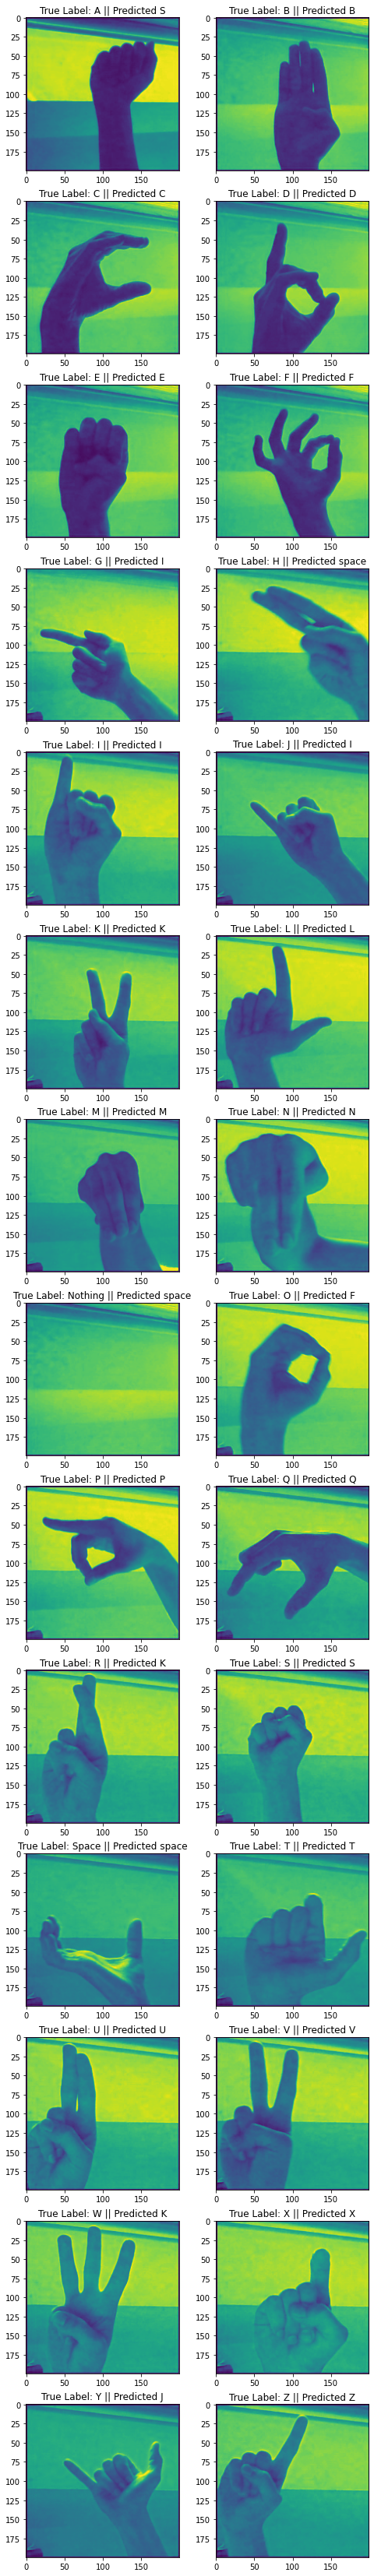

In [16]:
plt.figure()

fig, axes = plt.subplots(14, 2, figsize = (8, 60))

for i, img in enumerate(test_imgs):

    plt.subplot(14, 2, i + 1)
    
    plt.imshow(img[0].reshape(200, 200))
    plt.title(f'True Label: {test_labels[i]} || Predicted {predictions[i]}')

plt.show()